<a href="https://colab.research.google.com/github/victordaniel/Deeplearning/blob/master/Copy_of_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image, ImageTk
from scipy import ndimage
from lr_utils import load_dataset

#----------------------Load and clean the dataset----------------------------------------

#Load the data (cat/not cat dataset)

#Lets visualize the train set
print(train_set_x_orig)
print(train_set_y)
print(classes)

#Example of image to test and see if the import worked
#index = 20
#plt.imshow(train_set_x_orig[index])
#print("y = " + str(train_set_y[:,index]) + ", it's a '" + classes[np.squeeze(train_set_y[:,index])].decode("utf-8") + "' picture.")

#Lets get some basic data about our image numpy arrays
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print("Number of training examples: m_train = " + str(m_train))
print("Number of test examples: m_test = " + str(m_test))
print("Height/Width of each image: num_px = " + str(num_px))
print("Each image is of size: ("+ str(num_px) + ", " + str(num_px) + ", 3)")
print("train_set_x shape: " + str(train_set_x_orig.shape))
print("train_set_y shape: " + str(train_set_y.shape))
print("test_set_x shape : " + str(test_set_x_orig.shape))
print("test_set_y shape: "+ str(test_set_y.shape))

#Will now flatten the numpy array from (num_px, num_px, 3) to (num_px*num_px*3, 1) 
#this will make it easier for us so that each image in one numpy array column
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print("train_set_y shape: " + str(train_set_y.shape))
print("test_set_x_flatten shape: "+ str(test_set_x_flatten.shape))
print("test_set_y shape: "+ str(test_set_y.shape))

#Standardize the dataset for images by dividing each by 255
train_set_x = train_set_x_flatten/255
test_set_x = test_set_x_flatten/255

#--------------------------Build the Logisitic Regression framework-------------------------

#We will be using a sigmoid function for our Activation, in Neural Networks most are not ReLU due to speed of calc

def sigmoid(z):
    s = 1/(1+np.exp(-(z)))
    return s

#Create function to set both w and b to 0 to start with
def initialize_with_zeros(dim):
    w = np.zeros((dim,1))
    b = 0
    return w,b

#Create a function that calculates the current SSE
def propagate(w, b, X, Y):
    m = X.shape[1]
    A = sigmoid(np.dot(w.T,X)+b)
    cost = -1/m * np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))
    dw = (1/m) * (np.dot(X,(A-Y).T))
    db = (1/m) * (np.sum(A-Y))
    
    cost = np.squeeze(cost)
    
    grads = {"dw": dw, "db": db}
    
    return grads, cost

#Create a function that moves the estimates around and calculates the SSE to find optimal w and b
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    costs = []
    for i in range(num_iterations):
        grads, cost = propagate(w,b,X,Y)
        dw = grads["dw"]
        db = grads["db"]
        w = w-learning_rate*dw
        b = b-learning_rate*db
        if i % 100 == 0:
            costs.append(cost)
        if print_cost and i % 100 == 0:
            print("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w":w,"b":b}
    grads = {"dw":dw,"db":db}
    
    return params, grads, costs

def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0],1)
    A = sigmoid(np.dot(w.T,X)+b)
    for i in range(A.shape[1]):
        if A[0,i] <= 0.5:
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1
            
    return Y_prediction

#----------------------Merge all the components in to a model----------------------------

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    global D
    #Initialize paramters with 0
    w,b = initialize_with_zeros(X_train.shape[0])
    #Perform Gradient Descent
    parameters, grads, costs = optimize(w,b,X_train,Y_train,num_iterations,learning_rate,print_cost)
    #Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    #Predict test/train set examples
    Y_prediction_test = predict(w,b,X_test)
    Y_prediction_train = predict(w,b,X_train)
    #Print train/test errors
    print("train accuracy: {} %".format(100-np.mean(np.abs(Y_prediction_train-Y_train))*100))
    print("test accuracy: {} %".format(100-np.mean(np.abs(Y_prediction_test-Y_test))*100))
    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train": Y_prediction_train,
         "w":w,
         "b":b,
         "learning_rate": learning_rate,
         "num_iterations": num_iterations}
    D = d


#----------------------Test on our own image----------------------------------------

def run_on_own_image(my_image):
    fname = my_image
    image = np.array(ndimage.imread(fname,flatten=False))
    my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((1,num_px*num_px*3)).T
    my_predicted_image = predict(D["w"], D["b"],my_image)
    
    #plt.imshow(image)
    print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicted a \"" 
      + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") + "\" picture.")
    labelText = tk.Label(text="Your algorithm predicted a " + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8"))
    labelText.text = "Your algorithm predicted a " + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8")
    labelText.pack()    
    img = Image.open(fname)
    img = img.resize((300,300), Image.ANTIALIAS)
    photo = ImageTk.PhotoImage(img)
    label = tk.Label(image=photo)
    label.image = photo
    label.pack()

def choose_file():
    global fileNameGlobal
    filename = askopenfilename()
    fileNameGlobal = filename
#--------------------------Run the model------------------------------------------------

#d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=0.005, print_cost=True)
import tkinter as tk
from tkinter.filedialog import askopenfilename

master = tk.Tk()

trainButton = tk.Button(master, text="Train Model", command = lambda: model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=0.005, print_cost=True))
trainButton.pack()

fileButton = tk.Button(master, text="Choose your own file", command=choose_file)
fileButton.pack()

ownImageButton = tk.Button(master, text="Test Own Image", command = lambda: run_on_own_image(fileNameGlobal))
ownImageButton.pack()

tk.mainloop()

In [3]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np 
import struct
import matplotlib.pyplot as plt


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.chdir('/content/drive/My Drive')
os.listdir('/content/drive/My Drive/mnist/')
def read_image_file(fname):
   fin = open(fname,'rb');
   mnum =  struct.unpack('>i',fin.read(4)) 
   nimages =  struct.unpack('>i',fin.read(4)) 
   nrows =   struct.unpack('>i',fin.read(4)) 
   ncols =   struct.unpack('>i',fin.read(4)) 
   dim = nrows[0]*ncols[0] ;
   x = np.array(list(fin.read()));
   x = x.reshape(nimages[0],dim);
   fin.close()
   return x;
def read_label_file(fname):
   fin = open(fname,'rb');
   mnum =  struct.unpack('>i',fin.read(4))
   nimages =  struct.unpack('>i',fin.read(4))  
   x = np.array(list(fin.read()));
   x = x.reshape(nimages[0],1);
   fin.close()
   return x;

In [0]:
X = read_image_file('mnist/train-images-idx3-ubyte');
Y = read_label_file('mnist/train-labels-idx1-ubyte');
test_x = read_image_file('mnist/t10k-images-idx3-ubyte');
test_y = read_label_file('mnist/t10k-labels-idx1-ubyte');

In [6]:
print(X.shape)
print(Y.shape)

(60000, 784)
(60000, 1)


[3]
(784,)


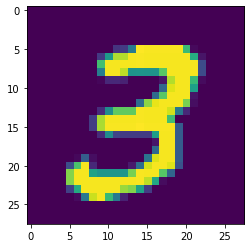

In [7]:
# display one image # 

print(Y[7,:]);
print(X[7,:].shape)
x = X[7,:].reshape(28,28);

plt.imshow(x.astype('uint8'));
plt.show()

Task 1 
 Learn a logistic regression classifier to 
 distinguish number three from rest of the classes 
'''



Task 1 Learn a logistic regression classifier to distinguish number three from rest of the classes 

# Make a new array with `1' label for class 3 and `0' 
# label for other classes

In [0]:
array=np.array(1)

# Initialize the weights, bias



In [9]:
rows=X.shape[1]
w=np.zeros((60000,784))
b=np.zeros(784)
print(w.shape)

(60000, 784)


# Compute the Cross Entropy # (consider writing a function)
# Print it 


In [1]:
#To compute loss ,first compute the predictions
o=np.dot(X,w.T)+b
#apply sigmoid 
h_x=1/(1+np.exp(-o))


m=X.shape[0]

#compute cross entropy
J1 = (np.sum((Y*np.log(h_x))+((1-Y)*np.log(1-h_x)))  ) 
J= (-1/m)*cost1 

#print cross entorpy
print(J)


NameError: ignored

In [0]:
## Implement gradient descent 
for i in range(100): # start with 100 epochs 
    print(i); # print epoch number

    # Compute gradients

    # update weights

# Reshape the weight into a 28x28 image 
# and do imshow 

## Perform testing 


## Find the accuracy on test data 


## Implement gradient descent

In [56]:
for i in range(100): # start with 100 epochs 
    print(i); # print epoch number

    # Compute gradients
    dw = np.dot((h_x-Y).T,X)
    db1=((h_x-Y))
    db = db1
    # update weights
    alpha=0.0001
    w=w-alpha*dw
    b=b-alpha*db

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


[3]
(28,)


TypeError: ignored

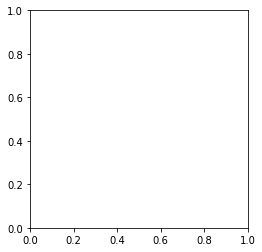

In [65]:
print(Y[7,:]);
x = w[7,:].T
print(x.shape)
#.reshape(28,28);

plt.imshow(x.astype('uint8'));
plt.show()

In [21]:
m_train = X.shape
m_test = test_x.shape[0]
num_px = X.shape[1]
print(m_train)


(60000, 784)


In [9]:
print(m_train),print(m_test),print(num_px)

print("Number of training examples: m_train = " + str(m_train))
print("Number of test examples: m_test = " + str(m_test))
print("Height/Width of each image: num_px = " + str(num_px))
print("Each image is of size: ("+ str(num_px) + ", " + str(num_px) + ", 3)")
print("train_set_x shape: " + str(X.shape))
print("train_set_y shape: " + str(Y.shape))
print("test_set_x shape : " + str(test_x.shape))
print("test_set_y shape: "+ str(test_y.shape))
"""
#Will now flatten the numpy array from (num_px, num_px, 3) to (num_px*num_px*3, 1) 
#this will make it easier for us so that each image in one numpy array column
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print("train_set_y shape: " + str(train_set_y.shape))
print("test_set_x_flatten shape: "+ str(test_set_x_flatten.shape))
print("test_set_y shape: "+ str(test_set_y.shape))

#Standardize the dataset for images by dividing each by 255
train_set_x = train_set_x_flatten/255
test_set_x = test_set_x_flatten/255
"""


(60000, 784)
10000
784
Number of training examples: m_train = (60000, 784)
Number of test examples: m_test = 10000
Height/Width of each image: num_px = 784
Each image is of size: (784, 784, 3)
train_set_x shape: (60000, 784)
train_set_y shape: (60000, 1)
test_set_x shape : (10000, 784)
test_set_y shape: (10000, 1)


'\n#Will now flatten the numpy array from (num_px, num_px, 3) to (num_px*num_px*3, 1) \n#this will make it easier for us so that each image in one numpy array column\ntrain_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T\ntest_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T\n\nprint("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))\nprint("train_set_y shape: " + str(train_set_y.shape))\nprint("test_set_x_flatten shape: "+ str(test_set_x_flatten.shape))\nprint("test_set_y shape: "+ str(test_set_y.shape))\n\n#Standardize the dataset for images by dividing each by 255\ntrain_set_x = train_set_x_flatten/255\ntest_set_x = test_set_x_flatten/255\n'

In [0]:
def sigmoid(z):
    s = 1/(1+np.exp(-(z)))
    return s

#Create function to set both w and b to 0 to start with
def initialize_with_zeros(dim):
    w = np.zeros((dim,1))
    b = 0
    return w,b

#Create a function that calculates the current SSE
def propagate(w, b, X, Y):
    m = X.shape[1]
    A = sigmoid(np.dot(w.T,X)+b)
    cost = -1/m * np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))
    dw = (1/m) * (np.dot(X,(A-Y).T))
    db = (1/m) * (np.sum(A-Y))
    
    cost = np.squeeze(cost)
    
    grads = {"dw": dw, "db": db}
    
    return grads, cost

#Create a function that moves the estimates around and calculates the SSE to find optimal w and b
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    costs = []
    for i in range(num_iterations):
        grads, cost = propagate(w,b,X,Y)
        dw = grads["dw"]
        db = grads["db"]
        w = w-learning_rate*dw
        b = b-learning_rate*db
        if i % 100 == 0:
            costs.append(cost)
        if print_cost and i % 100 == 0:
            print("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w":w,"b":b}
    grads = {"dw":dw,"db":db}
    
    return params, grads, costs

def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0],1)
    A = sigmoid(np.dot(w.T,X)+b)
    for i in range(A.shape[1]):
        if A[0,i] <= 0.5:
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1
            
    return Y_prediction


In [0]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    global D
    #Initialize paramters with 0
    w,b = initialize_with_zeros(X_train.shape[0])
    #Perform Gradient Descent
    parameters, grads, costs = optimize(w,b,X_train,Y_train,num_iterations,learning_rate,print_cost)
    #Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    #Predict test/train set examples
    Y_prediction_test = predict(w,b,X_test)
    Y_prediction_train = predict(w,b,X_train)
    #Print train/test errors
    print("train accuracy: {} %".format(100-np.mean(np.abs(Y_prediction_train-Y_train))*100))
    print("test accuracy: {} %".format(100-np.mean(np.abs(Y_prediction_test-Y_test))*100))
    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train": Y_prediction_train,
         "w":w,
         "b":b,
         "learning_rate": learning_rate,
         "num_iterations": num_iterations}
    D = d


#----------------------Test on our own image----------------------------------------

def run_on_own_image(my_image):
    fname = my_image
    image = np.array(ndimage.imread(fname,flatten=False))
    my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((1,num_px*num_px*3)).T
    my_predicted_image = predict(D["w"], D["b"],my_image)
    
    #plt.imshow(image)
    print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicted a \"" 
      + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") + "\" picture.")
    labelText = tk.Label(text="Your algorithm predicted a " + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8"))
    labelText.text = "Your algorithm predicted a " + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8")
    labelText.pack()    
    img = Image.open(fname)
    img = img.resize((300,300), Image.ANTIALIAS)
    photo = ImageTk.PhotoImage(img)
    label = tk.Label(image=photo)
    label.image = photo
    label.pack()

def choose_file():
    global fileNameGlobal
    filename = askopenfilename()
    fileNameGlobal = filename
#--------------------------Run the model------------------------------------------------

d = model(X, Y, test_x, test_y, num_iterations=100, learning_rate=0.005, print_cost=True)
import tkinter as tk
from tkinter.filedialog import askopenfilename

master = tk.Tk()

trainButton = tk.Button(master, text="Train Model", command = lambda: model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=0.005, print_cost=True))
trainButton.pack()

fileButton = tk.Button(master, text="Choose your own file", command=choose_file)
fileButton.pack()

ownImageButton = tk.Button(master, text="Test Own Image", command = lambda: run_on_own_image(fileNameGlobal))
ownImageButton.pack()

tk.mainloop()
